In [1]:
from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import torch
import lightning as pl
from ipsl_dcpp.model.pangu import PanguWeather
from hydra import compose, initialize
from omegaconf import OmegaConf

import hydra
import os
os.environ['SLURM_NTASKS_PER_NODE'] = '1'
#torch.set_default_dtype(torch.float32)
# os.environ["CUDA_VISIBLE_DEVICES"]=""
#torch.set_default_tensor_type(torch.FloatTensor)

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
pl.seed_everything(cfg.experiment.seed)
train = hydra.utils.instantiate(
    cfg.experiment.train_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    normalization='climatology',
    delta=True,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)

train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size=1,
    shuffle=False,
    num_workers=1
)

#batch = next(iter(train_dataloader))
model = hydra.utils.instantiate(
    cfg.experiment.module,
    backbone=hydra.utils.instantiate(
        cfg.experiment.backbone,
    ),
    dataset=train_dataloader.dataset

)

Seed set to 0
/Users/gclyne/miniforge3/envs/env_dcpp/lib/python3.12/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/Users/gclyne/miniforge3/envs/env_dcpp/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025535429/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
checkpoint_path = torch.load(f'../epoch=02.ckpt',map_location=torch.device('cpu'))
model.load_state_dict(checkpoint_path['state_dict'])


<All keys matched successfully>

In [3]:
batch = next(iter(train_dataloader))
batch['time']

['1962-01']

In [16]:
dataloader_iter = iter(train_dataloader)
batch = next(next(next(next(next(next(dataloader_iter))))))

In [4]:
num_ensemble_members = 1

samples = [model.sample(batch, num_inference_steps=10, 
                                denormalize=False, 
                                scheduler='ddpm', 
                                seed = j) for j in range(num_ensemble_members)]


In [8]:
samples[0][1][5].mean()

tensor(-0.0094)

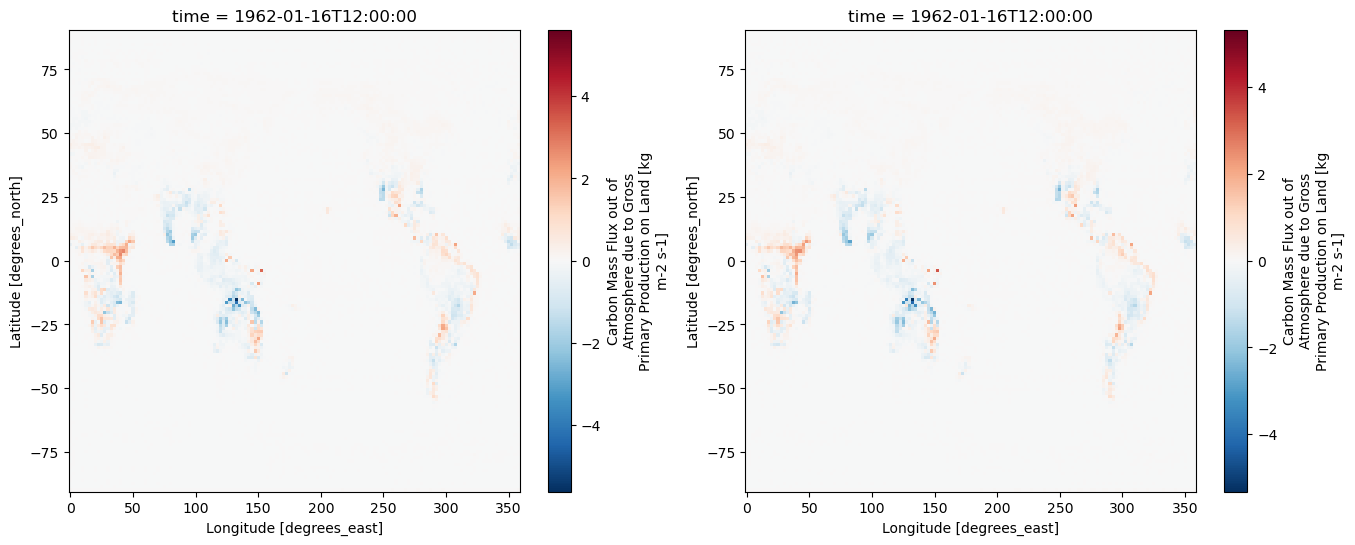

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
#get shell
ds = xr.open_dataset(train.files[0])
shell = ds.isel(time=0)
var_name = 'gpp'
var_index = cfg.experiment.surface_variables.index(var_name)

#plot lat lon map of first rollout
fig, ax1 = plt.subplots(1, 2, figsize=(16, 6))
ax1=ax1.flatten()
shell[var_name].data = samples[0][1][9]
shell[var_name].plot.pcolormesh(ax=ax1[0])
shell[var_name].data = samples[0][1][8]
shell[var_name].plot.pcolormesh(ax=ax1[1])

In [50]:
np.nanmean(samples[1]['next_state_surface'])

88484050.0

In [52]:
samples_batch = [x[1] for x in samples]

KeyError: 1

In [9]:
import matplotlib.pyplot as plt
for i in range(num_ensemble_members):
    samples[i]['next_state_surface'].squeeze()[90]
plt.show()


In [33]:
import numpy as np
gpp_samples = np.stack([samples[i]['next_state_surface'].squeeze()[90] for i in range(num_ensemble_members)])

In [36]:
std_gpp = gpp_samples.std(axis=0)
gpp_mean_predicted = gpp_samples.mean(axis=0)


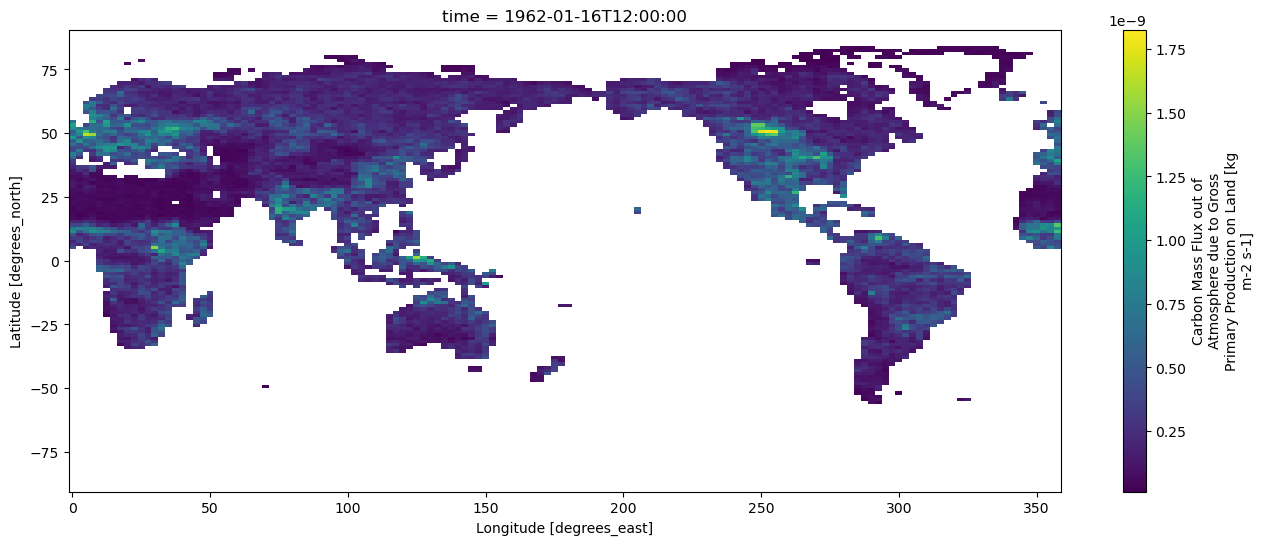

In [35]:
import xarray as xr
import matplotlib.pyplot as plt
#get shell
ds = xr.open_dataset(train.files[0])
shell = ds.isel(time=0)
var_name = 'gpp'
var_index = cfg.experiment.surface_variables.index(var_name)

#plot lat lon map of first rollout
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))
shell[var_name].data = std_gpp
shell[var_name].plot.pcolormesh(ax=ax1)

In [38]:
#calculate ensemble mean 
import xarray as xr 
import numpy as np
gpp_ensemble = []
for i in range(1,10):
    ipsl_ensemble = xr.open_dataset(f'../data/1961_{i}.nc')
    gpp_ensemble.append(ipsl_ensemble['gpp'][6].data)

gpp_std = np.stack(gpp_ensemble).std(axis=0)
gpp_mean = np.stack(gpp_ensemble).mean(axis=0)



In [45]:
np.nanmean(np.power((gpp_mean - gpp_mean_predicted),2))


1.4078561e-15

In [ ]:
shell = ipsl_ensemble.isel(time=0)
shell['gpp'].data = gpp_std

#plot
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1, 1, figsize=(16, 6))

shell['gpp'].plot.pcolormesh(ax=ax1)